# Predicting the success of a crowdfunding campaign
### By: Colby Shelton

According to Fundly.com, the crowdfunding industry has raised 34 billion dollars and it is projected to grow to over 300 billion dollars by 2025!

Considering only about 50% of campaigns succeed globally, there's definitely room for that figure to increase even more.

I want to build a machine learning model that can predict if a crowdfunding campaign will succeed before it's launched.

A model that can predict if a campaign will succeed before it’s launch would provide great value to any crowdfunding product team.

It would save the team time, money, and frustration.

# The data

The data I used for this project can be found on Kaggle.com here: https://www.kaggle.com/kemical/kickstarter-projects.

It was gathered directly from Kickstarter.com on campaign ran from 2May09 - 2Mar18.

In [76]:
# General 
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

# Features pre-processing and principal component analysis (pca) 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

# Train-test split
from sklearn.model_selection import train_test_split

# Classifiers 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Classifiers evaluation metrics
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

# Random resampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Tuning hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Other
from time import time
import calendar
from scipy.stats import ttest_ind
from scipy.stats.mstats import winsorize

# Ploting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
from IPython.display import display
pd.options.display.float_format = '{:.3f}'.format

# Suppressing annoying harmless error
import warnings
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [37]:
# Import the data
df = pd.read_csv('/Users/colby/Desktop/Thinkful/kickstarter-projects/ks-projects-201801.csv')

# Get inital insight:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.000,2015-08-11 12:12:28,0.000,failed,0,GB,0.000,0.000,1533.950
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.000,2017-09-02 04:43:57,2421.000,failed,15,US,100.000,2421.000,30000.000
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.000,2013-01-12 00:20:50,220.000,failed,3,US,220.000,220.000,45000.000
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.000,2012-03-17 03:24:11,1.000,failed,1,US,1.000,1.000,5000.000
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.000,2015-07-04 08:35:03,1283.000,canceled,14,US,1283.000,1283.000,19500.000


In [38]:
# Get length/width of dataframe
df.shape

(378661, 15)

In [39]:
df.nunique()

ID                  378661
name                375764
category               159
main_category           15
currency                14
deadline              3164
goal                  8353
launched            378089
pledged              62130
state                    6
backers               3963
country                 23
usd pledged          95455
usd_pledged_real    106065
usd_goal_real        50339
dtype: int64

In [40]:
# Get count/data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


# Data Cleaning and Exploration

## Examine missing data

In [41]:
# Verifying null-values.
print(df.isnull().sum())

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


Missing data does not seem to be a problem here since one variable has fewer than 10 observations missing except for "usd pledged" variable. Since we're predicting success BEFORE launch (any money raised), this variable is unnecessary. I will remove it along with other unnecessary variables which includes repeats.

In [42]:
# Drop unnecessary/repeat variables
df = df.drop(['ID', 'goal', 'pledged', 'usd pledged', 'backers', 'currency', 'country'], axis=1)

In [43]:
# Get length/width of dataframe
df.shape

(378661, 8)

In [44]:
# Drop missing data
df=df.dropna(axis=0, how='any')

## Feature Engineering

In [47]:
# Perhaps the name-length of the project affects the success.
# Let's create a variable based on the number of words in 'name'

# Remove '&'s form name
df['name'] = df['name'].str.replace('&','and')

# Remove punctuation
df['name'] = df['name'].str.replace(r'[^\w\s]+', '')

# Convert to string
df['name'] = df['name'].astype(str)

# Create new variable as the number of words in name
df['name_total_words'] = [len(x.split()) for x in df['name'].tolist()]

In [49]:
# Create campaign duration measured in days using 'deadline' and 'launched' date variables
df['deadline'] = pd.to_datetime(df['deadline']).dt.date
df['launched'] = pd.to_datetime(df['launched']).dt.date
df['campaign_length'] = (df['deadline'] - df['launched']).dt.days

In [54]:
# Create feature for month of campaign launch

df['launch_month'] = pd.DatetimeIndex(df['launched']).month

# Turn numeric indicator of month to a string i.e.: 12 =='Dec'
d = dict(enumerate(calendar.month_abbr))
df['launch_month'] = df['launch_month'].map(d)

In [56]:
# Create feature for day of month of campaign launch

df['launch_day_ofmonth'] = pd.DatetimeIndex(df['launched']).day

In [57]:
# Create feature for week of month of campaign launch

df['launch_week_ofmonth'] = df['launched'].apply(lambda d: (d.day-1) // 7 + 1)

In [58]:
# Create feature for week of year of campaign launch

df['launch_week_ofyear'] = pd.DatetimeIndex(df['launched']).week

In [59]:
# Create feature for weekday of campaign launch

df['launch_weekday'] = pd.DatetimeIndex(df['launched']).weekday_name

In [60]:
# Get length/width of dataframe
df.shape

(378657, 15)

In [61]:
df.dtypes

name                    object
category                object
main_category           object
deadline                object
launched                object
state                   object
usd_pledged_real       float64
usd_goal_real          float64
name_total_words         int64
campaign_length          int64
launch_month            object
launch_day_ofmonth       int64
launch_week_ofmonth      int64
launch_week_ofyear       int64
launch_weekday          object
dtype: object

In [62]:
# Verifying null-values.
df.isnull().sum()

name                   0
category               0
main_category          0
deadline               0
launched               0
state                  0
usd_pledged_real       0
usd_goal_real          0
name_total_words       0
campaign_length        0
launch_month           0
launch_day_ofmonth     0
launch_week_ofmonth    0
launch_week_ofyear     0
launch_weekday         0
dtype: int64

In [63]:
# deleling data what "state" isn't failed or successful

df = df[ (df['state'] != 'live') & (df['state'] != 'undefined') & (df['state'] != 'suspended') & (df['state'] != 'canceled') ]

In [65]:
# Get length/width of dataframe
df.shape

(331672, 15)

In [66]:
print('Deleting all rows besides those where STATE == failed/successful leaves {}% of the rows.'.format(331672 / 378657))

Deleting all rows besides those where STATE == failed/successful leaves 0.8759167267474258% of the rows.


# Create Dummy Variable for target variable

In [67]:
# Create binary variables from 'state' and add the variable to the dataframe

pd.get_dummies(df["state"])
df = pd.concat([df, pd.get_dummies(df["state"])], axis=1)

# Target variable: 'State'

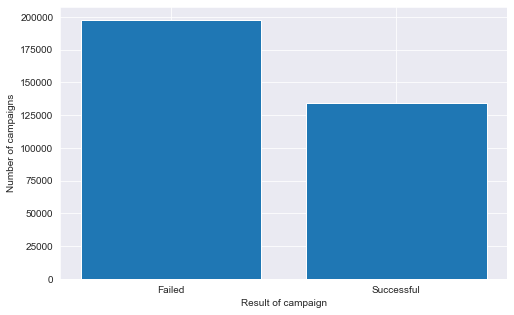

In [68]:
plt.figure(figsize=(8,5))
sns.set_style('darkgrid')

plt.hist(df.state, bins=np.arange(3)-0.5, rwidth=0.8)
plt.xlabel("Result of campaign")
plt.xticks(range(0,2), ['Failed', 'Successful'])
plt.ylabel('Number of campaigns')
plt.savefig('Target_var2.png')

plt.show()

In [71]:
print("Distribution of campaign outcomes:")
print("{}".format(df.state.value_counts([0])))

Distribution of campaign outcomes:
failed       0.596
successful   0.404
Name: state, dtype: float64


# Numerical variables

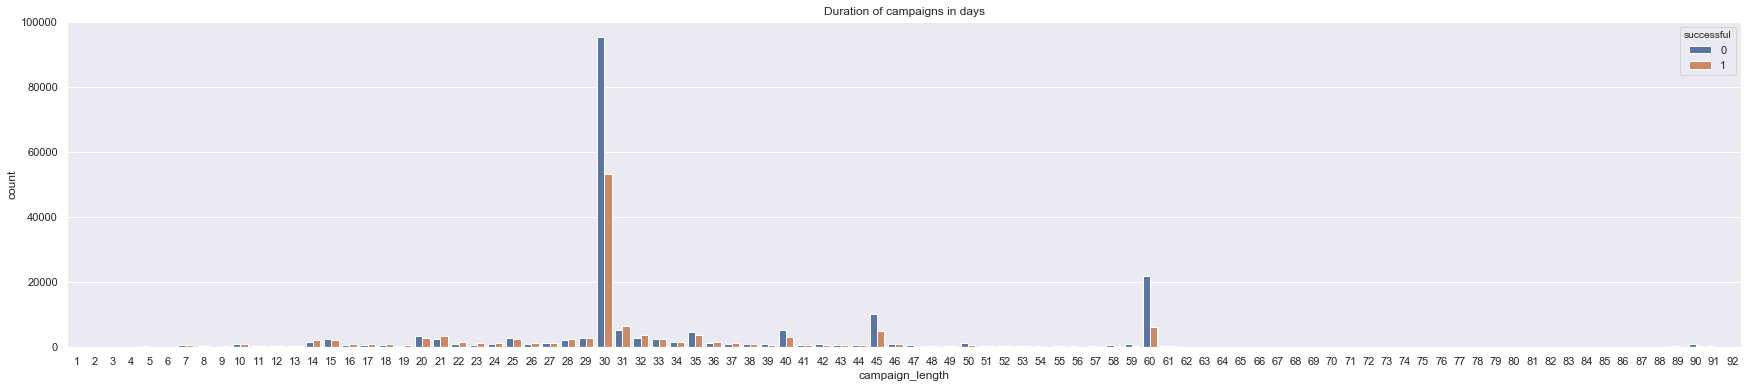

In [73]:
# Count plot of campaign_length
sns.set(style="darkgrid")
plt.figure(figsize=(30,6))

plt.xlabel("Number of Days")
plt.ylabel("Campaigns")
plt.title('Duration of campaigns in days')
sns.countplot(x = df['campaign_length'], hue="successful", data=df)
plt.savefig('campaign_length.png')

plt.show()

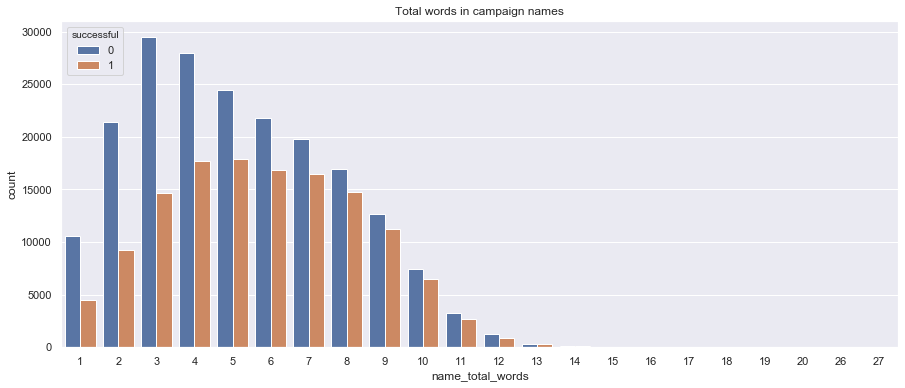

In [74]:
# Count plot of name_total_words 
sns.set(style="darkgrid")
plt.figure(figsize=(15,6))

plt.xlabel("Number of words")
plt.ylabel("Campaigns")
plt.title('Total words in campaign names')
sns.countplot(x = df['name_total_words'], hue="successful", data=df)
plt.savefig('name_total_words.png')

plt.show()

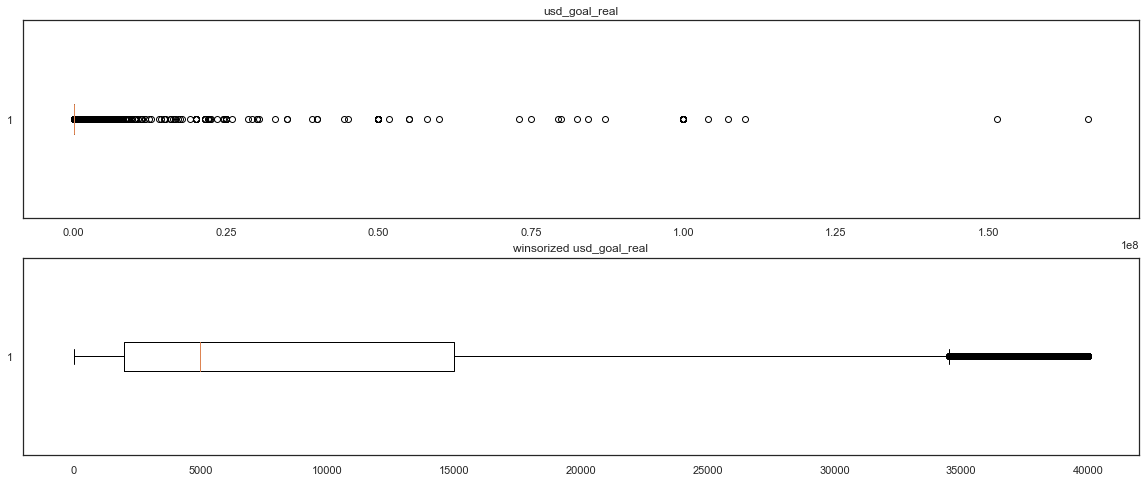

In [77]:
# Barplot of usd_goal_real and winsorized usd_goal_real

plt.figure(figsize=(20,8))

plt.subplot(2,1,1)
original_usd_goal_real = df['usd_goal_real']
plt.boxplot(original_usd_goal_real, vert=False)
plt.title("usd_goal_real")
plt.savefig('usd_goal_real.png')

plt.subplot(2,1,2)
winsorized_usd_goal_real = winsorize(df['usd_goal_real'], (0, 0.10))
plt.boxplot(winsorized_usd_goal_real, vert=False)
plt.title("winsorized usd_goal_real")
plt.savefig('winsorized usd_goal_real.png')

plt.show()

Due to outliers, I decided to use winzorization and kept all data points within the 95th percentile.

In [78]:
# Check number of Outliers before Winsorization for each variable.
num_outliers = [df['usd_goal_real']]

for variable in num_outliers:
    q75, q25 = np.percentile(variable, [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    print("Number of outliers before winsorization : {}".format(len(np.where((variable > max_val) | (variable < min_val))[0])))

Number of outliers before winsorization : 39047


In [79]:
# Apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 75th percentile. 

winsorized_usd_goal_real = winsorize(df['usd_goal_real'],(0,0.15))

In [80]:
# Check number of Outliers after Winsorization for each variable.
win_list = [winsorized_usd_goal_real]

for variable in win_list:
    q75, q25 = np.percentile(variable, [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    print("Number of outliers after winsorization : {}".format(len(np.where((variable > max_val) | (variable < min_val))[0])))

Number of outliers after winsorization : 0


In [81]:
# Adding winsorized variables to the data frame.

df['winsorized_usd_goal_real'] = winsorized_usd_goal_real

# Categorical variables

In [82]:
# Define a functin to perform a chi-squared test of independence
def chi_sq_test(col1, col2):
    counttable=pd.crosstab(df[col1], df[col2])
    print(counttable)
    print(stats.chisquare(counttable, axis=None))

In [83]:
# Define a function to print countplots
def count_plot(col1):
    sns.set(style="darkgrid")
    plt.figure(figsize=(12,6))
    sns.countplot(x = df[col1], hue="successful", data=df)
    plt.tight_layout()

# Main category of campaign

Chi-squared test of independence between main category and success of campaign


main_category    Art  Comics  Crafts  Dance  Design  Fashion  Film & Video  \
successful                                                                   
0              14130    4036    5703   1235   14814    14182         32903   
1              11510    5842    2115   2338   10550     5593         23623   

main_category   Food  Games  Journalism  Music  Photography  Publishing  \
successful                                                                
0              15969  16002        3137  21752         6384       23145   
1               6085  12518        1012  24197         3305       12300   

main_category  Technology  Theater  
successful                          
0                   20616     3708  
1                    6434     6534  
Power_divergenceResult(statistic=180839.73279625655, pvalue=0.0)


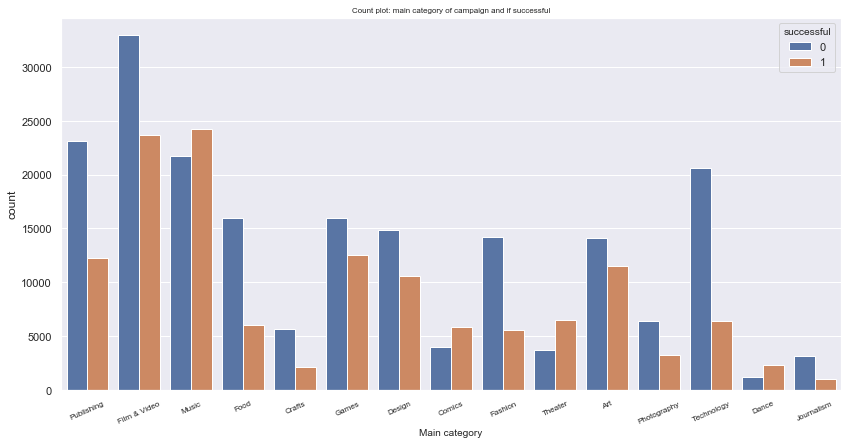

In [85]:
# Count plot  
count_plot('main_category')
plt.xlabel('Main category', fontsize= 10)
plt.xticks(rotation=24, fontsize= 8)
plt.title('Count plot: main category of campaign and if successful', fontsize= 8)
plt.savefig('main_category.png')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between main category and success of campaign')
print('\n')
chi_sq_test('successful','main_category')

# Month of launch

Chi-squared test of independence between Day of launch and success of campaign


launch_month    Apr    Aug    Dec    Feb    Jan    Jul    Jun    Mar    May  \
successful                                                                    
0             16484  17585  11620  15274  14932  20326  17200  17249  17113   
1             12093  10820   6842  11003   9480  11681  11773  12851  12062   

launch_month    Nov    Oct    Sep  
successful                         
0             16733  17025  16175  
1             11770  12350  11231  
Power_divergenceResult(statistic=17614.621770906197, pvalue=0.0)


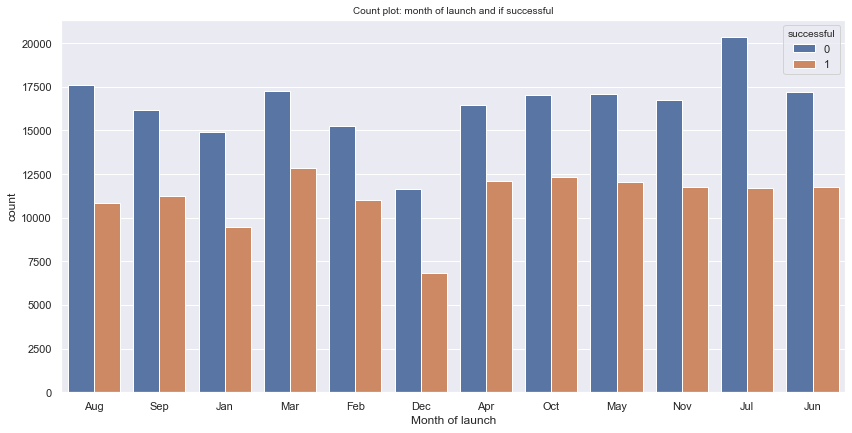

In [86]:
# Count plot  
count_plot('launch_month')
plt.xlabel('Month of launch')
plt.title('Count plot: month of launch and if successful', fontsize= 10)
plt.savefig('month_of_launch.png')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between Day of launch and success of campaign')
print('\n')
chi_sq_test('successful','launch_month')

# Day of Month

Chi-squared test of independence between Day of month of launch and success of campaign


launch_day_ofmonth    1     2     3     4     5     6     7     8     9   \
successful                                                                 
0                   7659  6707  6481  6406  6479  6567  6562  6757  7249   
1                   6423  4928  4571  4394  4341  4463  4584  4445  4488   

launch_day_ofmonth    10  ...    22    23    24    25    26    27    28    29  \
successful                ...                                                   
0                   6805  ...  6357  6273  6219  5955  5773  6042  6090  5756   
1                   4655  ...  4124  4020  4114  3992  3893  3835  3954  3714   

launch_day_ofmonth    30    31  
successful                      
0                   5840  3726  
1                   3760  2478  

[2 rows x 31 columns]
Power_divergenceResult(statistic=16414.13386719409, pvalue=0.0)


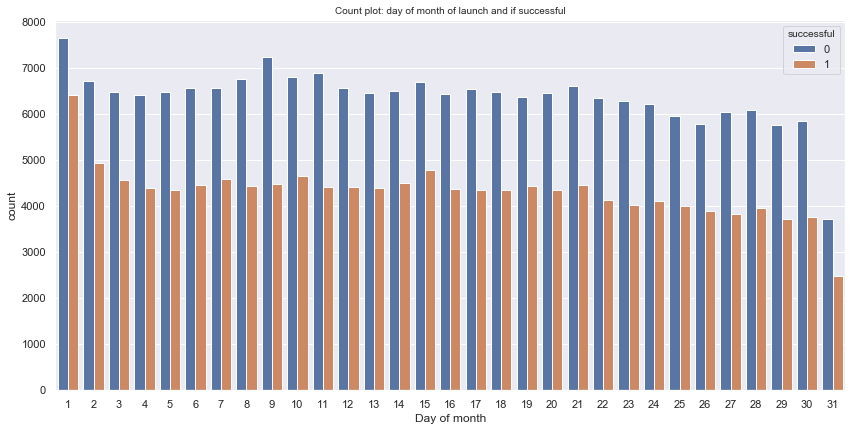

In [87]:
# Count plot  
count_plot('launch_day_ofmonth')
plt.xlabel('Day of month')
plt.title('Count plot: day of month of launch and if successful', fontsize= 10)
plt.savefig('launch_day_ofmonth.png')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between Day of month of launch and success of campaign')
print('\n')
chi_sq_test('successful','launch_day_ofmonth')

# Week of month

Chi-squared test of independence between week of month of launch and success of campaign


launch_week_ofmonth      1      2      3      4      5
successful                                            
0                    46861  47233  45591  42709  15322
1                    33704  31289  31079  27932   9952
Power_divergenceResult(statistic=45941.29150486023, pvalue=0.0)


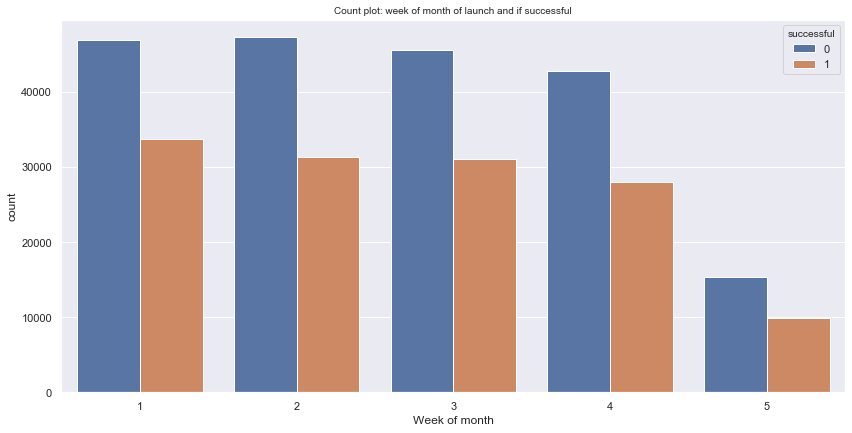

In [88]:
# Count plot  
count_plot('launch_week_ofmonth')
plt.xlabel('Week of month')
plt.title('Count plot: week of month of launch and if successful', fontsize= 10)
plt.savefig('launch_week_ofmonth.png')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between week of month of launch and success of campaign')
print('\n')
chi_sq_test('successful','launch_week_ofmonth')

# Day of week

Chi-squared test of independence between weekday of launch launch and success of campaign


launch_weekday  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
successful                                                                    
0                31423   31745     17859   10896     31744    38916      35133
1                19923   21761     10694    7393     21365    28787      24033
Power_divergenceResult(statistic=52083.880809956834, pvalue=0.0)


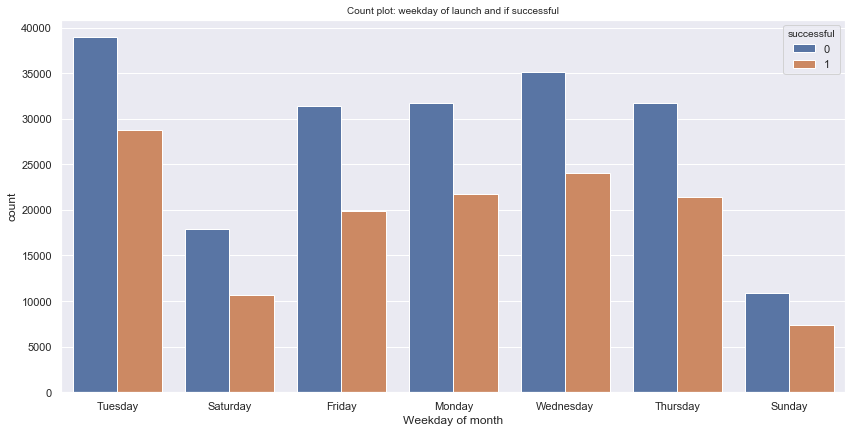

In [89]:
# Count plot  
count_plot('launch_weekday')
plt.xlabel('Weekday of month')
plt.title('Count plot: weekday of launch and if successful', fontsize= 10)
plt.savefig('launch_weekday.png')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between weekday of launch launch and success of campaign')
print('\n')
chi_sq_test('successful','launch_weekday')

# Week of year

Chi-squared test of independence between Week of year launch and success of campaign


launch_week_ofyear    1     2     3     4     5     6     7     8     9   \
successful                                                                 
0                   2735  3171  3393  3692  3889  3706  3822  3749  3924   
1                   1602  1978  2186  2448  2741  2716  2747  2579  3011   

launch_week_ofyear    10  ...    44    45    46    47    48    49    50    51  \
successful                ...                                                   
0                   3996  ...  4063  3992  4285  3887  3382  3329  2872  2455   
1                   3054  ...  2995  2721  3103  2594  2201  2134  1704  1457   

launch_week_ofyear    52   53  
successful                     
0                   1796  500  
1                    969  166  

[2 rows x 53 columns]
Power_divergenceResult(statistic=25257.957343399506, pvalue=0.0)


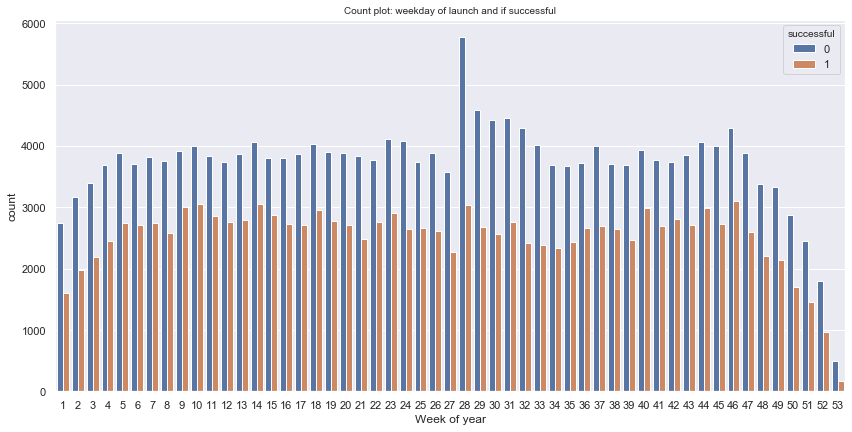

In [90]:
# Count plot  
count_plot('launch_week_ofyear')
plt.xlabel('Week of year')
plt.title('Count plot: weekday of launch and if successful', fontsize= 10)
plt.savefig('launch_week_ofyear.png')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between Week of year launch and success of campaign')
print('\n')
chi_sq_test('successful','launch_week_ofyear')

# Feature Engineering

In [91]:
df.describe(include='all')

,name,category,main_category,deadline,launched,state,usd_pledged_real,usd_goal_real,name_total_words,campaign_length,launch_month,launch_day_ofmonth,launch_week_ofmonth,launch_week_ofyear,launch_weekday,failed,successful,winsorized_usd_goal_real
count,331672,331672,331672,331672,331672,331672,331672.000,331672.000,331672.000,331672.000,331672,331672.000,331672.000,331672.000,331672,331672.000,331672.000,331672.000
unique,328914,159,15,3102,3151,2,nan,nan,nan,nan,12,nan,nan,nan,7,nan,nan,nan
top,New EPMusic Development,Product Design,Film & Video,2014-08-08,2014-07-09,failed,nan,nan,nan,nan,Jul,nan,nan,nan,Tuesday,nan,nan,nan
freq,15,18680,56526,612,780,197716,nan,nan,nan,nan,32007,nan,nan,nan,67703,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,NaN,9943.549,41509.659,5.441,33.955,NaN,15.285,2.643,26.153,NaN,0.596,0.404,9202.300
std,NaN,NaN,NaN,NaN,NaN,NaN,96733.367,1108934.642,2.621,12.713,NaN,8.814,1.264,14.400,NaN,0.491,0.491,8841.781
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.010,1.000,1.000,NaN,1.000,1.000,1.000,NaN,0.000,0.000,0.010
25%,NaN,NaN,NaN,NaN,NaN,NaN,50.000,2000.000,3.000,30.000,NaN,8.000,2.000,14.000,NaN,0.000,0.000,2000.000
50%,NaN,NaN,NaN,NaN,NaN,NaN,788.000,5000.000,5.000,30.000,NaN,15.000,3.000,26.000,NaN,1.000,0.000,5000.000
75%,NaN,NaN,NaN,NaN,NaN,NaN,4608.000,15000.000,7.000,36.000,NaN,23.000,4.000,39.000,NaN,1.000,1.000,15000.000


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 18 columns):
name                        331672 non-null object
category                    331672 non-null object
main_category               331672 non-null object
deadline                    331672 non-null object
launched                    331672 non-null object
state                       331672 non-null object
usd_pledged_real            331672 non-null float64
usd_goal_real               331672 non-null float64
name_total_words            331672 non-null int64
campaign_length             331672 non-null int64
launch_month                331672 non-null object
launch_day_ofmonth          331672 non-null int64
launch_week_ofmonth         331672 non-null int64
launch_week_ofyear          331672 non-null int64
launch_weekday              331672 non-null object
failed                      331672 non-null uint8
successful                  331672 non-null uint8
winsorized_usd_goal_real   

In [93]:
df.shape

(331672, 18)

# Create dummy variables

In [94]:
# Convert categirical variables into present/absent or dummy variables
df=pd.get_dummies(df, columns=['state', 'launch_weekday', 'launch_month', 'launch_day_ofmonth', 'launch_week_ofmonth', 
                                       'launch_week_ofyear', 'main_category'])

# Drop unnecessary variables

In [95]:
df.drop(['name','category', 'deadline', 'launched', 'usd_pledged_real', 'state_failed', 'usd_goal_real', 'successful', 'failed'],
        axis=1,inplace=True)

# Correlation Heatmap

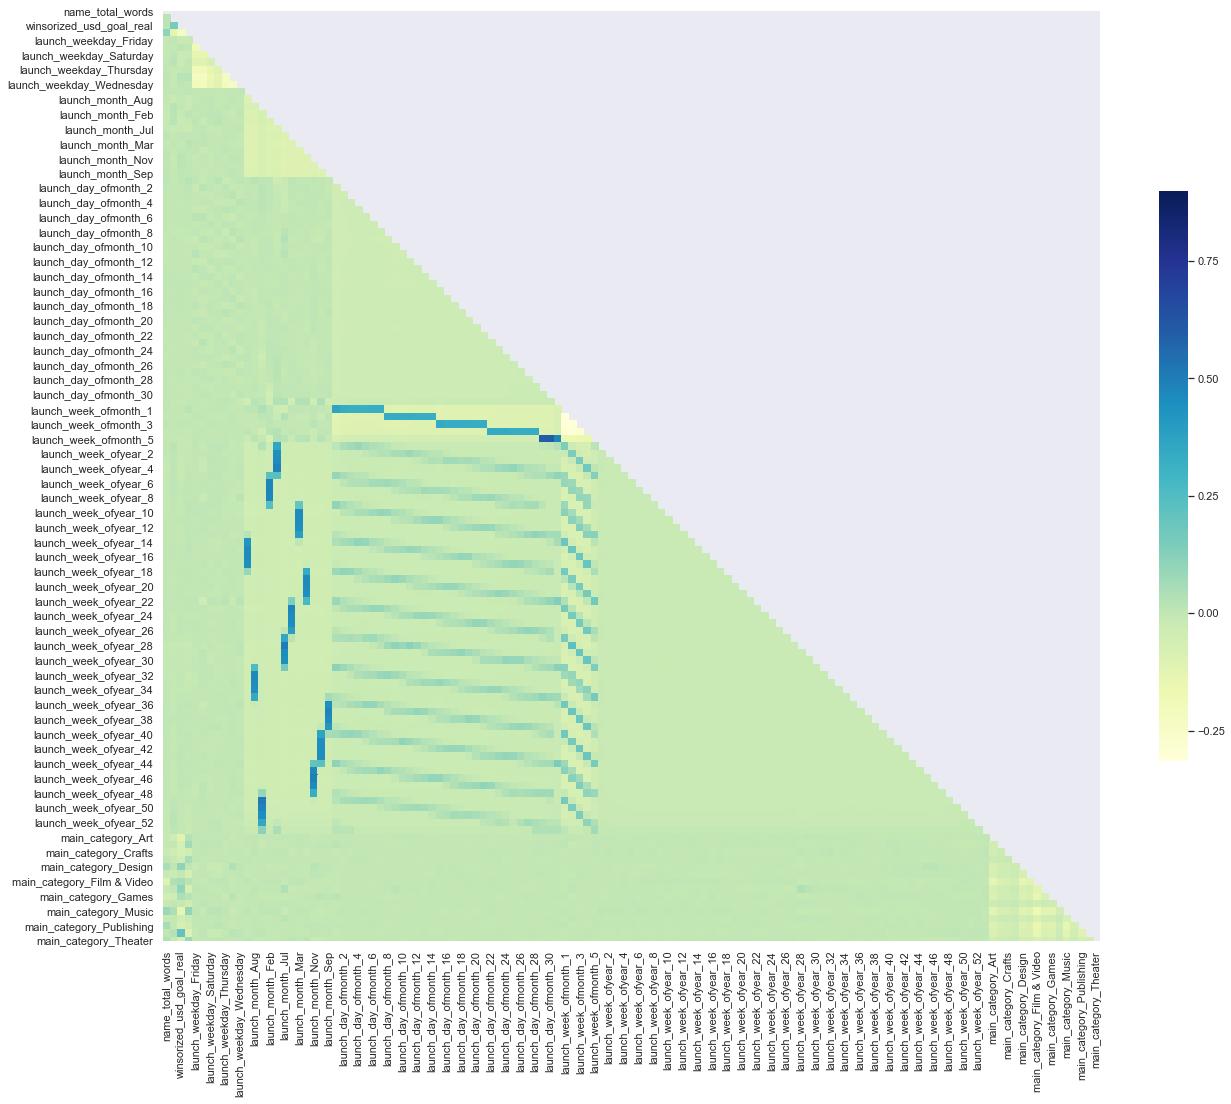

In [96]:
# Correlation heatmap
corrmat=df.corr()
plt.subplots(figsize=(21,21))
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrmat, mask=mask, vmax=0.9, cmap="YlGnBu", square=True, cbar_kws={"shrink": .5})

# Feature Selection

In [97]:
# Seperate outcome (y) and features (x)
y=df.loc[:,'state_successful']
x=df.loc[:, df.columns != 'state_successful']
print('Shape of y: \n', y.shape[0])
print('Shape of x: \n', x.shape)

Shape of y: 
 331672
Shape of x: 
 (331672, 126)


# Principal Component Analysis (PCA)

In [98]:
# Standardizing the features
x_stand = StandardScaler().fit_transform(x)

# PCA to keep 95% of variance
pca = PCA(0.95)

# Components required to keep 95% of variance
x_pca = pca.fit_transform(x_stand)

# Cumulative sum of explained variance by the components
var_cumsum=pca.explained_variance_ratio_.cumsum()
print(var_cumsum)
print('\n')
print('Need to keep {} components to explain 95% of the variance.'.format(len(var_cumsum)))

[0.02454202 0.04874224 0.06997413 0.08893042 0.10570007 0.12238723
 0.13901019 0.15549336 0.17186576 0.18812633 0.2042386  0.22027185
 0.23621232 0.25201471 0.2675351  0.27911402 0.29060693 0.30076402
 0.31087291 0.3208281  0.33061742 0.34040055 0.35008714 0.35967753
 0.36912053 0.3784102  0.387534   0.3965129  0.40545569 0.41437553
 0.42317619 0.43191652 0.44061047 0.44926625 0.45789723 0.46648986
 0.47505127 0.48353889 0.49201322 0.5004735  0.50892497 0.5173457
 0.5257413  0.53413129 0.54251859 0.55086437 0.5591932  0.56751345
 0.57582105 0.58411825 0.59238427 0.60064482 0.6088929  0.61712613
 0.62532752 0.63351263 0.64167925 0.64982026 0.65794774 0.66606542
 0.67416657 0.68226132 0.6903554  0.69844416 0.7065313  0.71460819
 0.7226792  0.73074808 0.73881128 0.74687026 0.75491719 0.76295062
 0.77097185 0.77897909 0.78698322 0.79497671 0.80296304 0.8109452
 0.81890534 0.82685878 0.83479748 0.84272553 0.85063952 0.85853753
 0.86639308 0.87424439 0.88206689 0.8898577  0.89763728 0.905384

<Figure size 432x432 with 0 Axes>

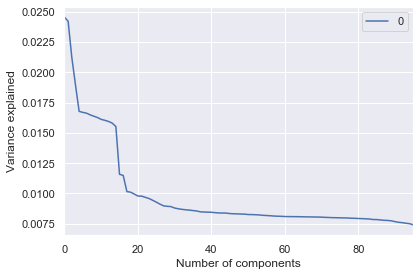

In [99]:
# Scree plot for PCA
plt.figure(figsize=(6,6))
pd.DataFrame(list(pca.explained_variance_ratio_)).plot(kind='line')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')
plt.savefig('PCA.png')

plt.tight_layout()
plt.show()

# Select k best features

In [100]:
# Select 20 k-best features
x_kbest = x[x.columns[SelectKBest(f_classif, k=20).fit(x, y).get_support()]]
print('{} K best features: \n'.format(x_kbest.columns))
print('Shape: ', x_kbest.shape)

Index(['name_total_words', 'campaign_length', 'winsorized_usd_goal_real',
       'launch_weekday_Tuesday', 'launch_month_Jul', 'launch_day_ofmonth_1',
       'launch_week_ofyear_28', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Fashion',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater'],
      dtype='object') K best features: 

Shape:  (331672, 20)


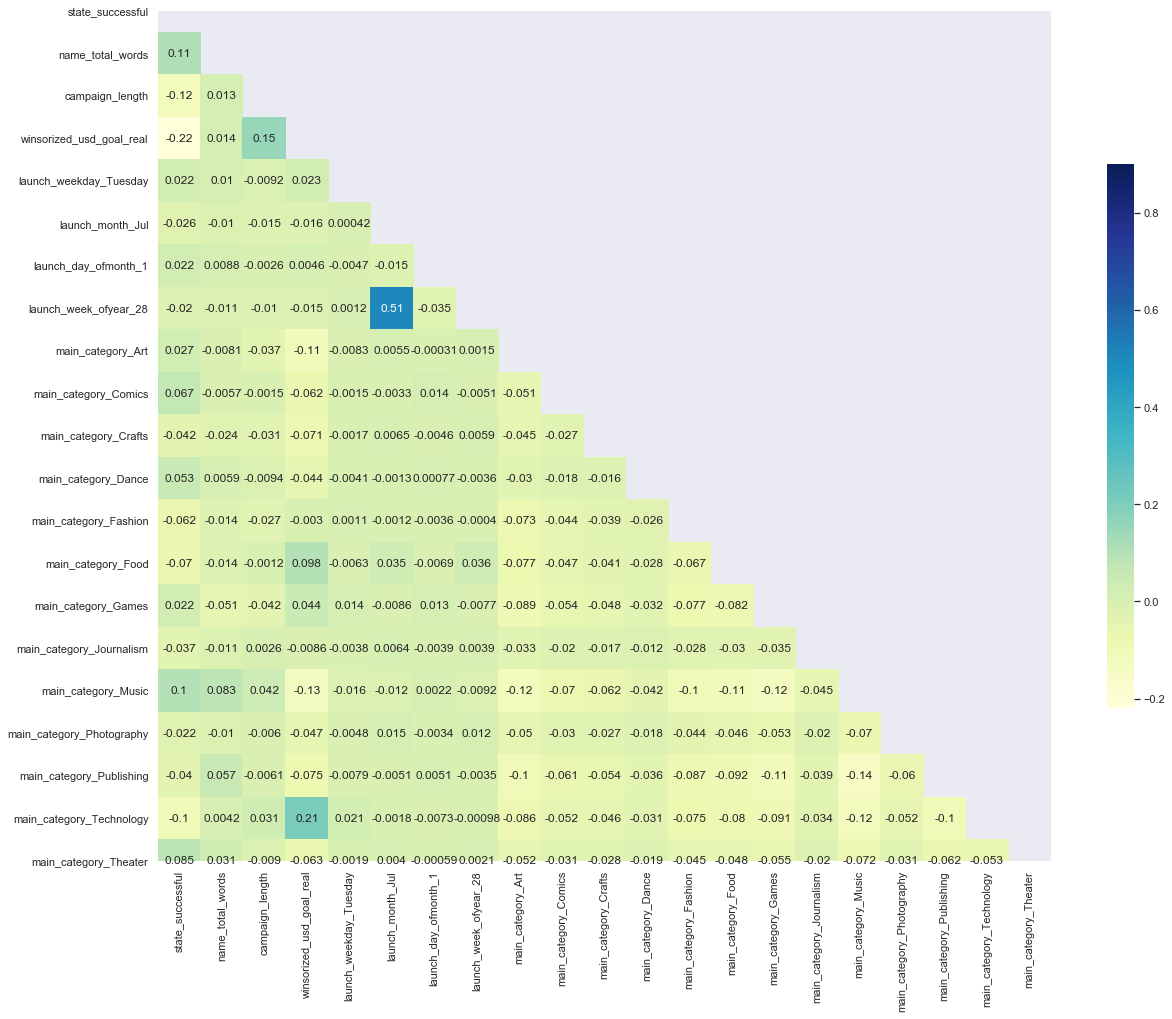

In [101]:
# Heatmap with k best features
df_kbest=pd.concat([y, x_kbest], axis=1)
corrmat=df_kbest.corr()
plt.subplots(figsize=(20,20))
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrmat, annot=True, mask=mask, vmax=0.9, cmap="YlGnBu", square=True, cbar_kws={"shrink": .5})
plt.savefig('Heatmap.png')

# Test/Train Split

In [102]:
# Split samples into train (80%) and test (20%) samples
X_train, X_test, y_train, y_test = train_test_split(x_kbest, y, test_size=0.2, random_state=321)
print('Train samples: ', X_train.shape)
print('Test samples: ', X_test.shape)

Train samples:  (265337, 20)
Test samples:  (66335, 20)


# Random under sampling of majority classes

In [103]:
# Random under sampling of majority class 
X_train_rus, y_train_rus, idx = RandomUnderSampler(random_state=321, return_indices=True).fit_sample(X_train, y_train)
print('Random under sampling {}\n'.format(Counter(y_train_rus)))

Random under sampling Counter({0: 107159, 1: 107159})



# Create function to fit, predict and then print outputs

In [104]:
# Define a function to fit, predict and then print outputs
def fit_eval_clf(model):
    start=time()
    #Fit the model in train samples
    prediction=model.fit(X_train_rus, y_train_rus).predict(X_test)
    
    # Cross-validated accuracy score
    accu_train = cross_val_score(model, X_train_rus, y_train_rus, cv=10, scoring='accuracy')
    print ("Cross-validated accuracy score on train samples: %.3f (+/- %.3f)" %(accu_train.mean(), 
                                                                                accu_train.std()*2))
    
    # Cros-validated area under ROC curve 
    au_roc_train = cross_val_score(model, X_train_rus, y_train_rus, cv=10, scoring='roc_auc')
    print ("Cross-validated area under ROC curve on train samples: %.3f (+/- %.3f)" %(au_roc_train.mean(), 
                                                                                      au_roc_train.std()*2))
    print('\n')
    # Accuracy score on test samples
    print ("Accuracy score on test samples: ", round(accuracy_score (y_test, prediction), 4))
    
    # Area under ROC on test samples
    print ("Area under ROC curve on test samples: ", round(roc_auc_score (y_test, prediction), 4))
    print('\n')
    print("Total time to run: %.2f minutes." % ((time() - start)/60))

# Create function to run cross validation on hyperparameters

In [105]:
def rand_search_cv(model, params):
    start=time()
    # Tune the hyperparameters via a randomized search
    rgrid = RandomizedSearchCV(model, params, random_state=321, scoring='roc_auc')
    rgrid.fit(X_train_rus, y_train_rus)
    print("Randomized search took %.2f minutes."% ((time() - start)/60))
    print('Best hyperparameters: ', rgrid.best_params_)

# Classifiers: Baseline performance

### KNN

In [107]:
print('KNN Classifier: Baseline performance\n')
fit_eval_clf(KNeighborsClassifier())

KNN Classifier: Baseline performance

Cross-validated accuracy score on train samples: 0.594 (+/- 0.006)
Cross-validated area under ROC curve on train samples: 0.627 (+/- 0.007)


Accuracy score on test samples:  0.5871
Area under ROC curve on test samples:  0.588


Total time to run: 1.85 minutes.


### Logistic Regression

In [108]:
print('Logistic Regression: Baseline performance\n')
fit_eval_clf(LogisticRegression(solver='liblinear',random_state=123))

Logistic Regression: Baseline performance

Cross-validated accuracy score on train samples: 0.616 (+/- 0.008)
Cross-validated area under ROC curve on train samples: 0.659 (+/- 0.012)


Accuracy score on test samples:  0.6057
Area under ROC curve on test samples:  0.6109


Total time to run: 0.18 minutes.


### Random Forest

In [109]:
print('Random Forest: Baseline performance\n')
fit_eval_clf(RandomForestClassifier(random_state=123))

Random Forest: Baseline performance



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cross-validated accuracy score on train samples: 0.606 (+/- 0.007)
Cross-validated area under ROC curve on train samples: 0.645 (+/- 0.008)


Accuracy score on test samples:  0.6088
Area under ROC curve on test samples:  0.6048


Total time to run: 1.05 minutes.


# Tune Models

### Tune K-Nearest Neighbors (KNN) Classifier

In [110]:
# Construct the set of hyperparameters to tune
params = {'n_neighbors':[5,6,7],
          'leaf_size':[1,2,3],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree']}
rand_search_cv(KNeighborsClassifier(), params)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Randomized search took 4.11 minutes.
Best hyperparameters:  {'weights': 'uniform', 'n_neighbors': 7, 'leaf_size': 1, 'algorithm': 'ball_tree'}


In [111]:
print('KNN Classifier: Performance after tuning hyperparameters\n')
fit_eval_clf(KNeighborsClassifier(weights='uniform', n_neighbors=7, leaf_size=1, algorithm='ball_tree'))

KNN Classifier: Performance after tuning hyperparameters

Cross-validated accuracy score on train samples: 0.600 (+/- 0.008)
Cross-validated area under ROC curve on train samples: 0.637 (+/- 0.010)


Accuracy score on test samples:  0.5924
Area under ROC curve on test samples:  0.5944


Total time to run: 1.87 minutes.


### Tune Logistic Regression

In [112]:
# Construct the set of hyperparameters to tune
params = {'C': [0.01, 0.1, 1, 5, 10],
         'penalty':['l1', 'l2'],
         'solver':['liblinear']}
rand_search_cv(LogisticRegression(random_state=321), params)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Randomized search took 0.20 minutes.
Best hyperparameters:  {'solver': 'liblinear', 'penalty': 'l1', 'C': 5}


In [113]:
print('Logistic Regression: Performance after tuning hyperparameters\n')
fit_eval_clf(LogisticRegression(C= 5, penalty= 'l1', random_state=123, solver='liblinear'))

Logistic Regression: Performance after tuning hyperparameters

Cross-validated accuracy score on train samples: 0.638 (+/- 0.008)
Cross-validated area under ROC curve on train samples: 0.689 (+/- 0.011)


Accuracy score on test samples:  0.632
Area under ROC curve on test samples:  0.6361


Total time to run: 0.19 minutes.


### Tune Random Forest

In [114]:
# Construct the set of hyperparameters to tune
params = {'max_depth': [ 10, 15, 20, 30, 40],
          'min_samples_leaf': [1, 3, 4, 7],
          'min_samples_split': [2, 5, 7, 9],
          'n_estimators': [100, 200, 500, 700]}
rand_search_cv(RandomForestClassifier(), params)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Randomized search took 20.76 minutes.
Best hyperparameters:  {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 20}


In [115]:
print('Random Forest: Performance after tuning hyperparameters \n')
fit_eval_clf(RandomForestClassifier(n_estimators = 500, min_samples_split = 2, min_samples_leaf = 7, max_depth = 20, 
                             random_state=123))

Random Forest: Performance after tuning hyperparameters 

Cross-validated accuracy score on train samples: 0.656 (+/- 0.010)
Cross-validated area under ROC curve on train samples: 0.714 (+/- 0.012)


Accuracy score on test samples:  0.6486
Area under ROC curve on test samples:  0.6547


Total time to run: 35.03 minutes.


# Feature Importance for top performing model (Random Forest)

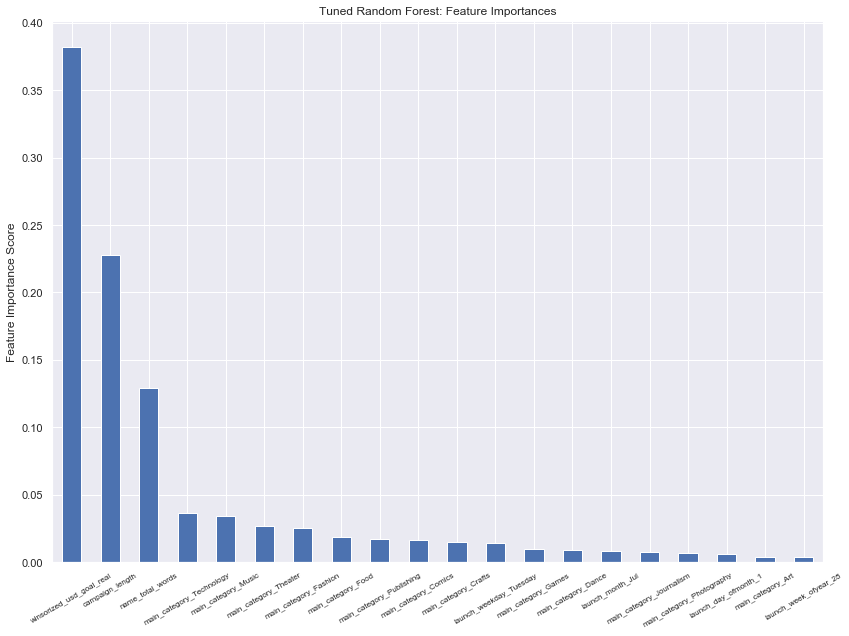

In [116]:
# Feature importances
model=RandomForestClassifier(n_estimators = 500, min_samples_split = 2, min_samples_leaf = 7, max_depth = 20, 
                             random_state=123)
model.fit(X_train_rus,y_train_rus)

feat_imp = pd.Series(model.feature_importances_, index=x_kbest.columns).sort_values(ascending=False)

# Set figure size
fig = plt.figure(figsize = (12,9))
ax = fig.gca()

feat_imp.plot(kind='bar', title='Tuned Random Forest: Feature Importances', ax=ax)
plt.ylabel('Feature Importance Score')
plt.xticks(fontsize=8, rotation=30)
plt.savefig('Feature_Importance_TunedRFC.png')
plt.tight_layout()
plt.show()

# Performance Evaluation

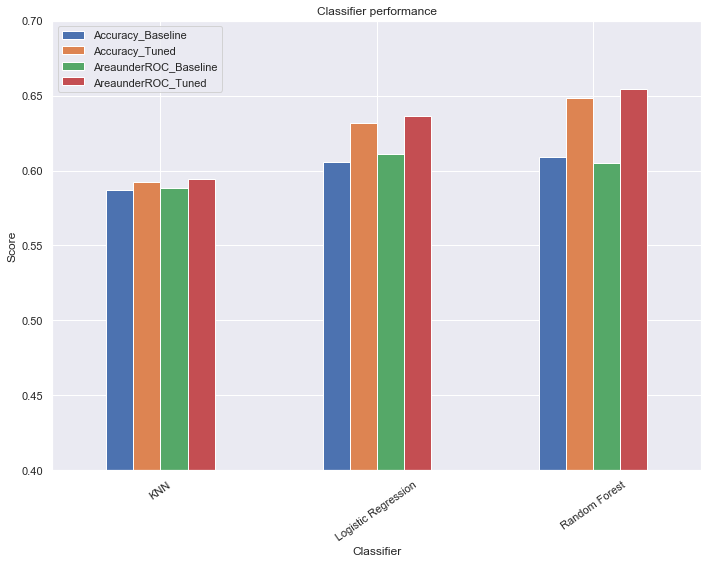

In [117]:
# Plot performances of baseline and tuned classifiers
clf_perform=pd.DataFrame({'Classifier': ['KNN', 'Logistic Regression', 'Random Forest'],
                          'Accuracy_Baseline': [0.5871, 0.6057, 0.6088],
                          'Accuracy_Tuned': [0.5924, 0.632, 0.6486],
                         'AreaunderROC_Baseline': [0.588, 0.6109, 0.6048], 
                         'AreaunderROC_Tuned': [0.5944, 0.6361, 0.6547]})
# Set figure size
fig = plt.figure(figsize = (10,8))
ax = fig.gca()

clf_perform.plot(kind='bar', x='Classifier', title='Classifier performance', ylim=[0.4,0.7], ax=ax)
plt.xticks(rotation=35)
plt.ylabel('Score')
plt.savefig('Classifier_Performance_Plot.png')
plt.tight_layout()

In [118]:
clf_perform

,Classifier,Accuracy_Baseline,Accuracy_Tuned,AreaunderROC_Baseline,AreaunderROC_Tuned
0,KNN,0.587,0.592,0.588,0.594
1,Logistic Regression,0.606,0.632,0.611,0.636
2,Random Forest,0.609,0.649,0.605,0.655


# Results

### The numbers

    Logistic Regression and Random Forest had similar baseline accuracy. 
        - (%60.6 vs %60.9)
    Random Forest had the greatest accuracy imporvement after tuning hyperparameters. 
        - (%64.9)
    - Random Forest much longer in terms of run time compared to Logistic Regression.
        - (RF = 35 minutes  vs. LR = 20 seconds)
    
• With campaign success odds currently sitting at 50/50 according to Fundly.com, but 60/40 according to Kickstarter data, I believe this model shows small results. 

• With accuracy currently at %64.9, there’s definitely room to improve.

• I believe this model is onto something in terms of providing value to a crowdfunding product team. 

• With further feature engineering, like that of using campaign name word count, there’s more creative insights to be discovered that will help improve model accuracy and give campaign managers insight on how to market their products (i.e. what to name the product knowing that the name word length and success rate are fairly correlated.)

# Next Steps / Future Work

    • Was pre-launch marketing performed? PPC?
    • How many emails were gathered?
    • How many updates were made to backers before/launch?
    • Average age of backer? (Know who to market to)
    • How many times was the campaign shared? (fewer than 2 shares == 97% chance of failure)
    • Who raised more than their goal?
    • Product description
    • Social following stats
    • Focused model on campaigns that raised 2x-20x their goal. Why/How?
    • Further experiments of campaign names and success (word difficulty, syllable count, does name explain product)
    • Perform ensemble methods on each model